In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = label_encoder.transform(data['mental_health_issue'])

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess the text for each model
X_train_lr = lr_vectorizer.transform(X_train)
X_test_lr = lr_vectorizer.transform(X_test)

X_train_svm = svm_vectorizer.transform(X_train)
X_test_svm = svm_vectorizer.transform(X_test)

X_train_nb = nb_vectorizer.transform(X_train)
X_test_nb = nb_vectorizer.transform(X_test)

X_train_xgb = tfidf_vectorizer.transform(X_train)
X_test_xgb = tfidf_vectorizer.transform(X_test)

X_train_lstm = lstm_tokenizer.texts_to_sequences(X_train)
X_train_lstm = pad_sequences(X_train_lstm, maxlen=100, padding='post', truncating='post')

X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get probabilities for training and testing
lr_train_proba = lr_model.predict_proba(X_train_lr)
lr_test_proba = lr_model.predict_proba(X_test_lr)

svm_train_proba = svm_model.predict_proba(X_train_svm)
svm_test_proba = svm_model.predict_proba(X_test_svm)

nb_train_proba = nb_model.predict_proba(X_train_nb)
nb_test_proba = nb_model.predict_proba(X_test_nb)

xgb_train_proba = xgb_model.predict_proba(X_train_xgb)
xgb_test_proba = xgb_model.predict_proba(X_test_xgb)

lstm_train_proba = lstm_model.predict(X_train_lstm)
lstm_test_proba = lstm_model.predict(X_test_lstm)

# Define weights for models (based on prior performance or experimentation)
weights = {
    'lr': 0.25,  # Logistic Regression
    'svm': 0.2,  # SVM
    'nb': 0.15,  # Naive Bayes
    'xgb': 0.25, # XGBoost
    'lstm': 0.15 # LSTM
}

# Weighted sum of probabilities
train_predictions_proba = (
    weights['lr'] * lr_train_proba +
    weights['svm'] * svm_train_proba +
    weights['nb'] * nb_train_proba +
    weights['xgb'] * xgb_train_proba +
    weights['lstm'] * lstm_train_proba
)

test_predictions_proba = (
    weights['lr'] * lr_test_proba +
    weights['svm'] * svm_test_proba +
    weights['nb'] * nb_test_proba +
    weights['xgb'] * xgb_test_proba +
    weights['lstm'] * lstm_test_proba
)

# Final predictions based on maximum weighted probability
train_predictions = np.argmax(train_predictions_proba, axis=1)
test_predictions = np.argmax(test_predictions_proba, axis=1)

# Evaluate weighted voting ensemble on test data
test_accuracy = accuracy_score(y_test, test_predictions)
test_report = classification_report(y_test, test_predictions, target_names=label_encoder.classes_)

print(f"Weighted Voting Ensemble Test Accuracy: {test_accuracy * 100:.2f}%")
print("Classification Report (Test Set):\n", test_report)
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, test_predictions))

# Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_accuracies = []

for train_idx, val_idx in kf.split(X, y):
    # Split the data
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Preprocess the data
    X_train_cv_lr = lr_vectorizer.transform(X_train_cv)
    X_val_cv_lr = lr_vectorizer.transform(X_val_cv)

    X_train_cv_svm = svm_vectorizer.transform(X_train_cv)
    X_val_cv_svm = svm_vectorizer.transform(X_val_cv)

    X_train_cv_nb = nb_vectorizer.transform(X_train_cv)
    X_val_cv_nb = nb_vectorizer.transform(X_val_cv)

    X_train_cv_xgb = tfidf_vectorizer.transform(X_train_cv)
    X_val_cv_xgb = tfidf_vectorizer.transform(X_val_cv)

    X_train_cv_lstm = lstm_tokenizer.texts_to_sequences(X_train_cv)
    X_train_cv_lstm = pad_sequences(X_train_cv_lstm, maxlen=100, padding='post', truncating='post')

    X_val_cv_lstm = lstm_tokenizer.texts_to_sequences(X_val_cv)
    X_val_cv_lstm = pad_sequences(X_val_cv_lstm, maxlen=100, padding='post', truncating='post')

    # Get probabilities
    lr_val_proba = lr_model.predict_proba(X_val_cv_lr)
    svm_val_proba = svm_model.predict_proba(X_val_cv_svm)
    nb_val_proba = nb_model.predict_proba(X_val_cv_nb)
    xgb_val_proba = xgb_model.predict_proba(X_val_cv_xgb)
    lstm_val_proba = lstm_model.predict(X_val_cv_lstm)

    # Weighted sum of probabilities
    val_predictions_proba = (
        weights['lr'] * lr_val_proba +
        weights['svm'] * svm_val_proba +
        weights['nb'] * nb_val_proba +
        weights['xgb'] * xgb_val_proba +
        weights['lstm'] * lstm_val_proba
    )

    # Final predictions based on maximum weighted probability
    val_predictions = np.argmax(val_predictions_proba, axis=1)

    # Calculate accuracy for the fold
    fold_accuracy = accuracy_score(y_val_cv, val_predictions)
    cross_val_accuracies.append(fold_accuracy)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {np.mean(cross_val_accuracies) * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {np.std(cross_val_accuracies) * 100:.2f}%")


465/465 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step
Weighted Voting Ensemble Test Accuracy: 95.15%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.95      0.92      0.94       400
     bipolar       0.96      0.74      0.84       388
  depression       0.92      0.94      0.93       392
      normal       0.95      1.00      0.97      2136
        ptsd       0.98      0.93      0.96       397

    accuracy                           0.95      3713
   macro avg       0.95      0.91      0.93      3713
weighted avg       0.95      0.95      0.95      3713

Confusion Matrix (Test Set):
 [[ 369    5   10   14    2]
 [   1  289   14   83    1]
 [  11    4  369    4    4]
 [   0    0    0 2135    1]
 [   7    3    8    8  371]]
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
117

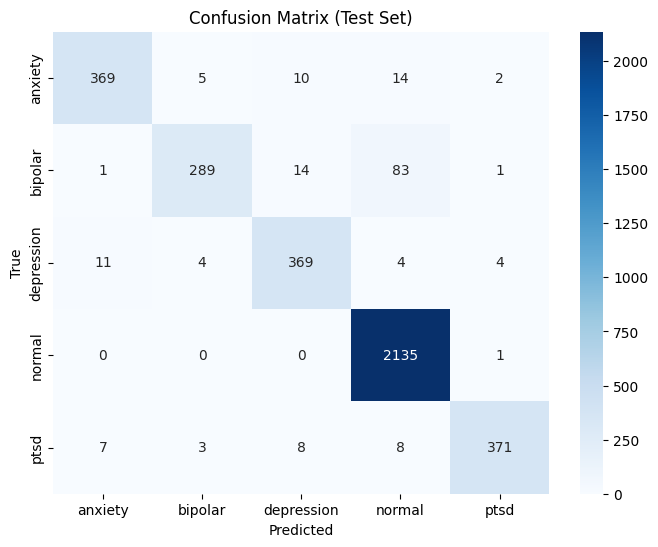

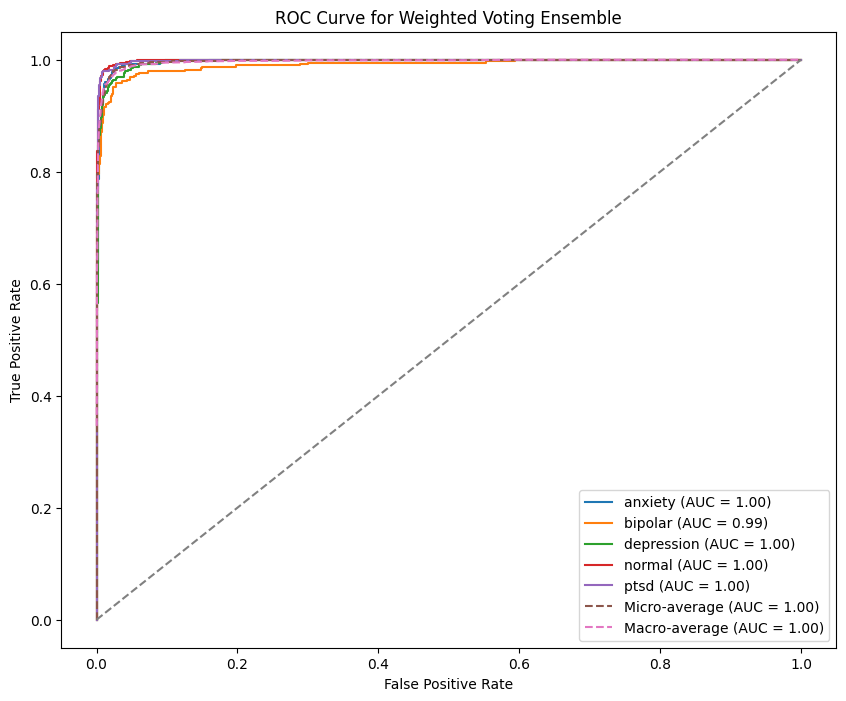

Micro-average AUC: 1.00
Macro-average AUC: 1.00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# ROC AUC Curve (One-vs-Rest)
# Get probability scores for test set
y_test_proba = test_predictions_proba

# Convert y_test to a one-hot encoded format for multi-class ROC AUC
y_test_one_hot = np.eye(len(label_encoder.classes_))[y_test]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_one_hot.ravel(), y_test_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(label_encoder.classes_)
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot ROC Curves
plt.figure(figsize=(10, 8))

# Individual class ROC curves
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle='--')

# Macro-average ROC curve
plt.plot(all_fpr, mean_tpr, label=f'Macro-average (AUC = {roc_auc_macro:.2f})', linestyle='--')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Weighted Voting Ensemble')
plt.legend(loc='lower right')
plt.show()

# Print overall AUC scores
print(f"Micro-average AUC: {roc_auc_micro:.2f}")
print(f"Macro-average AUC: {roc_auc_macro:.2f}")
